In [1]:
%cd D:\MastersFolder\2nd_year\Image_Processing_And_Analysis\Project

D:\MastersFolder\2nd_year\Image_Processing_And_Analysis\Project


In [7]:
#!pip install einops
  
import math

import six
from einops.layers.tensorflow import Rearrange
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard

from tensorflow.keras import datasets

import logging
import numpy as np

from fastprogress import master_bar, progress_bar
train_acc = []
val_acc = []
train_loss = []
val_loss = []
train_pre = []
val_pre = []
train_R = []
val_R = []

def gelu(x):
    """Gaussian Error Linear Unit.
    This is a smoother version of the RELU.
    Original paper: https://arxiv.org/abs/1606.08415
    Args:
        x: float Tensor to perform activation.
    Returns:
        `x` with the GELU activation applied.
    """
    cdf = 0.5 * (1.0 + tf.tanh(
        (math.sqrt(2 / math.pi) * (x + 0.044715 * tf.pow(x, 3)))))
    return x * cdf


def get_activation(identifier):
    """Maps a identifier to a Python function, e.g., "relu" => `tf.nn.relu`.
    It checks string first and if it is one of customized activation not in TF,
    the corresponding activation will be returned. For non-customized activation
    names and callable identifiers, always fallback to tf.keras.activations.get.
    Args:
        identifier: String name of the activation function or callable.
    Returns:
        A Python function corresponding to the activation function.
    """
    if isinstance(identifier, six.string_types):
        name_to_fn = {"gelu": gelu}
        identifier = str(identifier).lower()
        if identifier in name_to_fn:
            return tf.keras.activations.get(name_to_fn[identifier])
    return tf.keras.activations.get(identifier)


class Residual(tf.keras.Model):

    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def call(self, x):
        return self.fn(x) + x


class PreNorm(tf.keras.Model):

    def __init__(self, dim, fn):
        super().__init__()
        self.norm = tf.keras.layers.LayerNormalization(epsilon=1e-5)
        self.fn = fn

    def call(self, x):
        return self.fn(self.norm(x))


class FeedForward(tf.keras.Model):

    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = tf.keras.Sequential([tf.keras.layers.Dense(hidden_dim, activation=get_activation('gelu')),
                                        tf.keras.layers.Dense(dim)])

    def call(self, x):
        return self.net(x)

class Attention(tf.keras.Model):

    def __init__(self, dim, heads = 8):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5

        self.to_qkv = tf.keras.layers.Dense(dim * 3, use_bias=False)
        self.to_out = tf.keras.layers.Dense(dim)

        self.rearrange_qkv = Rearrange('b n (qkv h d) -> qkv b h n d', qkv = 3, h = self.heads)
        self.rearrange_out = Rearrange('b h n d -> b n (h d)')

    def call(self, x):
        qkv = self.to_qkv(x)
        qkv = self.rearrange_qkv(qkv)
        q = qkv[0]
        k = qkv[1]
        v = qkv[2]

        dots = tf.einsum('bhid,bhjd->bhij', q, k) * self.scale
        attn = tf.nn.softmax(dots,axis=-1)

        out = tf.einsum('bhij,bhjd->bhid', attn, v)
        out = self.rearrange_out(out)
        out =  self.to_out(out)
        return out

class Transformer(tf.keras.Model):

    def __init__(self, dim, depth, heads, mlp_dim):
        super().__init__()
        layers = []
        for _ in range(depth):
            layers.extend([
                Residual(PreNorm(dim, Attention(dim, heads = heads))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim)))
            ])
        self.net = tf.keras.Sequential(layers)

    def call(self, x):
        return self.net(x)

class ViT(tf.keras.Model):

    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels=3):
        super().__init__()
        assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2

        self.patch_size = patch_size
        self.dim = dim
        self.pos_embedding = self.add_weight("position_embeddings",
                                             shape=[num_patches + 1,
                                                    dim],
                                             initializer=tf.keras.initializers.RandomNormal(),
                                             dtype=tf.float32)
        self.patch_to_embedding = tf.keras.layers.Dense(dim)
        self.cls_token = self.add_weight("cls_token",
                                         shape=[1,
                                                1,
                                                dim],
                                         initializer=tf.keras.initializers.RandomNormal(),
                                         dtype=tf.float32)

        self.rearrange = Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=self.patch_size, p2=self.patch_size)

        self.transformer = Transformer(dim, depth, heads, mlp_dim)

        self.to_cls_token = tf.identity

        self.mlp_head = tf.keras.Sequential([tf.keras.layers.Dense(mlp_dim, activation=get_activation('gelu')),
                                        tf.keras.layers.Dense(num_classes)])

    @tf.function
    def call(self, img):
        shapes = tf.shape(img)

        x = self.rearrange(img)
        x = self.patch_to_embedding(x)

        cls_tokens = tf.broadcast_to(self.cls_token,(shapes[0],1,self.dim))
        x = tf.concat((cls_tokens, x), axis=1)
        x += self.pos_embedding
        x = self.transformer(x)

        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)
    
logger = logging.getLogger(__name__)


class TrainerConfig:
    # optimization parameters
    max_epochs = 10
    batch_size = 64
    learning_rate = 1e-3
    # checkpoint settings
    ckpt_path = None

    def __init__(self, **kwargs):
        for k, v in kwargs.items():
            setattr(self, k, v)
            
class Trainer:

    def __init__(self, model, model_config, train_dataset, train_dataset_len, test_dataset, test_dataset_len, config):
        self.train_dataset = train_dataset.batch(config.batch_size)
        self.train_dataset_len = train_dataset_len
        self.test_dataset = test_dataset
        self.test_dataset_len = None
        self.test_dist_dataset = None
        if self.test_dataset:
            self.test_dataset = test_dataset.batch(config.batch_size)
            self.test_dataset_len = test_dataset_len
        self.config = config
        self.tokens = 0
        self.strategy = tf.distribute.OneDeviceStrategy("GPU:0")
        if len(tf.config.list_physical_devices('GPU')) > 1:
            self.strategy = tf.distribute.MirroredStrategy()

        with self.strategy.scope():
            self.model = model(**model_config)
            self.optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)
            self.cce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.NONE)
            self.train_dist_dataset = self.strategy.experimental_distribute_dataset(self.train_dataset)
            if self.test_dataset:
                self.test_dist_dataset = self.strategy.experimental_distribute_dataset(self.test_dataset)

    def save_checkpoints(self):
        if self.config.ckpt_path is not None:
            self.model.save_weights(self.config.ckpt_path)


    def train(self):

        train_loss_metric = tf.keras.metrics.Mean('training_loss', dtype=tf.float32)
        test_loss_metric = tf.keras.metrics.Mean('testing_loss', dtype=tf.float32)

        train_accuracy = tf.keras.metrics.Accuracy('training_accuracy', dtype=tf.float32)
        test_accuracy = tf.keras.metrics.Accuracy('testing_accuracy', dtype=tf.float32)

        train_Precision_metric= tf.keras.metrics.Precision(dtype=tf.float32)
        test_Precision_metric= tf.keras.metrics.Precision(dtype=tf.float32)
        
        train_recall = tf.keras.metrics.Recall()
        test_recall = tf.keras.metrics.Recall()
        
        @tf.function
        def train_step(dist_inputs):

            def step_fn(inputs):

                X, Y = inputs

                with tf.GradientTape() as tape:
                # training=True is only needed if there are layers with different
                # behavior during training versus inference (e.g. Dropout).
                    logits = self.model(X,training=True)
                    num_labels = tf.shape(logits)[-1]
                    label_mask = tf.math.logical_not(Y < 0)
                    label_mask = tf.reshape(label_mask,(-1,))
                    logits = tf.reshape(logits,(-1,num_labels))
                    logits_masked = tf.boolean_mask(logits,label_mask)
                    label_ids = tf.reshape(Y,(-1,))
                    label_ids_masked = tf.boolean_mask(label_ids,label_mask)
                    cross_entropy = self.cce(label_ids_masked, logits_masked)
                    loss = tf.reduce_sum(cross_entropy) * (1.0 / self.config.batch_size)
                    y_pred = tf.argmax(tf.nn.softmax(logits,axis=-1),axis=-1)
                    train_accuracy.update_state(tf.squeeze(Y),y_pred)
                    train_Precision_metric.update_state(tf.squeeze(Y),y_pred)
                    train_recall.update_state(tf.squeeze(Y),y_pred)
                    
                grads = tape.gradient(loss, self.model.trainable_variables)
                self.optimizer.apply_gradients(list(zip(grads, self.model.trainable_variables)))
                return cross_entropy

            per_example_losses = self.strategy.run(step_fn, args=(dist_inputs,))
            sum_loss = self.strategy.reduce(tf.distribute.ReduceOp.SUM, per_example_losses, axis=0)
            mean_loss = sum_loss / self.config.batch_size
            return mean_loss

        @tf.function
        def test_step(dist_inputs):

            def step_fn(inputs):

                X, Y = inputs
                # training=True is only needed if there are layers with different
                # behavior during training versus inference (e.g. Dropout).
                logits = self.model(X,training=False)
                num_labels = tf.shape(logits)[-1]
                label_mask = tf.math.logical_not(Y < 0)
                label_mask = tf.reshape(label_mask,(-1,))
                logits = tf.reshape(logits,(-1,num_labels))
                logits_masked = tf.boolean_mask(logits,label_mask)
                label_ids = tf.reshape(Y,(-1,))
                label_ids_masked = tf.boolean_mask(label_ids,label_mask)
                cross_entropy = self.cce(label_ids_masked, logits_masked)
                loss = tf.reduce_sum(cross_entropy) * (1.0 / self.config.batch_size)
                y_pred = tf.argmax(tf.nn.softmax(logits,axis=-1),axis=-1)
                test_accuracy.update_state(tf.squeeze(Y),y_pred)
                test_Precision_metric.update_state(tf.squeeze(Y),y_pred)
                test_recall.update_state(tf.squeeze(Y),y_pred)
                
                return cross_entropy

            per_example_losses = self.strategy.run(step_fn, args=(dist_inputs,))
            sum_loss = self.strategy.reduce(tf.distribute.ReduceOp.SUM, per_example_losses, axis=0)
            mean_loss = sum_loss / self.config.batch_size
            return mean_loss

        train_pb_max_len = math.ceil(float(self.train_dataset_len)/float(self.config.batch_size))
        test_pb_max_len = math.ceil(float(self.test_dataset_len)/float(self.config.batch_size)) if self.test_dataset else None

        epoch_bar = master_bar(range(self.config.max_epochs))
        with self.strategy.scope():
            for epoch in epoch_bar:
                for inputs in progress_bar(self.train_dist_dataset,total=train_pb_max_len,parent=epoch_bar):
                    loss = train_step(inputs)
                    self.tokens += tf.reduce_sum(tf.cast(inputs[1]>=0,tf.int32)).numpy()
                    train_loss_metric(loss)
                    train_loss.append(train_loss_metric.result().numpy())
                    train_acc.append(train_accuracy.result().numpy())
                    train_pre.append(train_Precision_metric.result().numpy())
                    train_R.append(train_recall.result().numpy())   
                    epoch_bar.child.comment = f'training loss : {train_loss_metric.result()}'
                print(f"epoch {epoch+1}: train loss {train_loss_metric.result():.5f}. train accuracy {train_accuracy.result():.5f}")
                
                train_loss_metric.reset_states()
                train_accuracy.reset_states()

                if self.test_dist_dataset:
                    for inputs in progress_bar(self.test_dist_dataset,total=test_pb_max_len,parent=epoch_bar):
                        loss = test_step(inputs)
                        test_loss_metric(loss)
                        val_loss.append(test_loss_metric.result().numpy())
                        val_acc.append(test_accuracy.result().numpy())
                        val_pre.append(test_Precision_metric.result().numpy())
                        val_R.append(test_recall.result().numpy())
                        epoch_bar.child.comment = f'testing loss : {test_loss_metric.result()}'
                    print(f"epoch {epoch+1}: test loss {test_loss_metric.result():.5f}. test accuracy {test_accuracy.result():.5f}")
                    test_loss_metric.reset_states()
                    test_accuracy.reset_states()

                self.save_checkpoints()
                


In [3]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
import os
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize


X_ = "Database/Classification/Supervised/"
train_ids = next(os.walk(X_))[2]
X = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

for  n,id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = X_ + id_
    img = imread(path)[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS), mode='constant', preserve_range=True)
    X[n] = img  #Fill empty X_train with values from img
    
import pandas as pd
data = pd.read_csv('Database/Classification/Supervised.csv')
Y = data.drop(['image'],axis=1)




100%|██████████| 1400/1400 [00:34<00:00, 40.03it/s]


In [4]:
import sklearn.model_selection as model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, train_size=0.65,test_size=0.35, random_state=101)

train_images = tf.cast(X_train.reshape((-1, 3, 128, 128)),dtype=tf.float32)
test_images = tf.cast(X_test.reshape((-1, 3, 128, 128)),dtype=tf.float32)
train_images, test_images = train_images / 255.0, test_images / 255.0

train_x = tf.data.Dataset.from_tensor_slices(train_images,)
train_y = tf.data.Dataset.from_tensor_slices(y_train)
train_dataset = tf.data.Dataset.zip((train_x,train_y))
test_x = tf.data.Dataset.from_tensor_slices(test_images)
test_y = tf.data.Dataset.from_tensor_slices(y_test)
test_dataset = tf.data.Dataset.zip((test_x,test_y))


In [10]:
tconf = TrainerConfig(max_epochs=10,batch_size=64, learning_rate=1e-3)
# sample model config.
model_config = {"image_size":128,
                "patch_size":4,
                "num_classes":2,
                "dim":64,
                "depth":3,
                "heads":4,
                "mlp_dim":128}

trainer = Trainer(ViT, model_config, train_dataset, len(train_images), test_dataset, len(test_images), tconf)

In [11]:

tf.autograph.experimental.do_not_convert(trainer.train())

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

<function tensorflow.python.autograph.impl.api.do_not_convert(func=None)>

In [15]:
train_f1=[]
val_f1 = []
for i in range(len(train_pre)):
    train_f1.append(2* (train_pre[i]*train_R[i])/(train_pre[i]+train_R[i]))
    
for i in range(len(val_pre)):
    val_f1.append(2* (train_pre[i]*train_R[i])/(train_pre[i]+train_R[i]))

C:\Users\alen\AppData\Local\Temp/ipykernel_2376/610754211.py:4: RuntimeWarning: invalid value encountered in double_scalars
  train_f1.append(2* (train_pre[i]*train_R[i])/(train_pre[i]+train_R[i]))
C:\Users\alen\AppData\Local\Temp/ipykernel_2376/610754211.py:7: RuntimeWarning: invalid value encountered in double_scalars
  val_f1.append(2* (train_pre[i]*train_R[i])/(train_pre[i]+train_R[i]))


In [16]:
train_f1


[nan,
 0.49624060804198566,
 0.5357142857142857,
 0.46692607761355287,
 0.4166666666666667,
 0.41543029293015843,
 0.4746543930677858,
 0.5009487484835504,
 0.5288461194877171,
 0.5053598728029747,
 0.481751808110192,
 0.45643155850191086,
 0.4839506304229551,
 0.4999999404000231,
 0.5021645340126057,
 nan,
 0.49624060804198566,
 0.5357142857142857,
 0.46692607761355287,
 0.4166666666666667,
 0.380952382749681,
 0.4514563084467868,
 0.4831683209836679,
 0.514950152132951,
 0.49128368285513085,
 0.46757166171006437,
 0.44222540503376173,
 0.4200542178247633,
 0.4447115472692613,
 0.4483567901115275,
 0.476890762861231,
 0.49571023019332777,
 0.5035087955763897,
 0.4893436023734138,
 0.4767441780539441,
 0.4662875753305894,
 0.4541139414188499,
 0.44392886943574217,
 0.432880852852107,
 0.4453840653939559,
 0.45940593393239215,
 0.47742733817579214,
 0.4924330631084213,
 0.4999999403965205,
 0.5010917548660047,
 0.4914347227472337,
 0.48290372705854145,
 0.4761411037279094,
 0.4681285063

In [22]:
non_seg_train_acc = train_acc
non_seg_train_loss = train_loss
non_seg_val_acc = val_acc
non_seg_val_loss = val_loss
non_seg_train_R = train_R
non_seg_val_R = val_R
non_seg_train_f1 = train_f1
non_seg_val_f1 = val_f1


print("Train Accuracy = ",train_acc[len(train_acc)-1])
print("Train Loss = ",train_loss[len(train_loss)-1])

print("Validation Accuracy = ",val_acc[len(val_acc)-1])
print("Validation Loss = ",val_loss[len(val_loss)-1])


print("Train Recall =",train_R[len(train_R)-1])

print("Validation Recall = ",val_R[len(val_R)-1])


print("Train F1Score =",train_f1[len(train_f1)-1])

print("Validation F1Score =",val_f1[len(val_f1)-1])




Train Accuracy =  0.64395607
Train Loss =  0.5910567
Validation Accuracy =  0.62857145
Validation Loss =  0.64323235
Train Recall = 0.5526432
Validation Recall =  0.80406505
Train F1Score = 0.5645179725128633
Validation F1Score = 0.49836065740069874


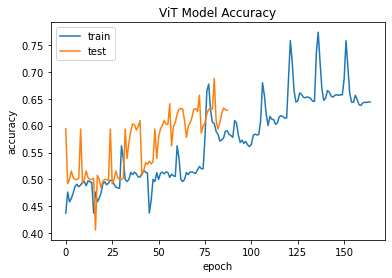

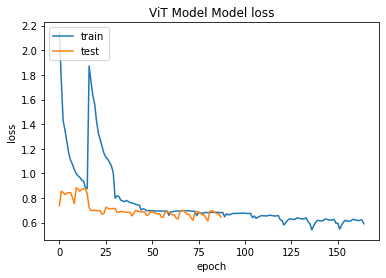

In [23]:
import matplotlib.pyplot as plt
# summarize history for accuracy
# summarize history for accuracy
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('ViT Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('ViT Model Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

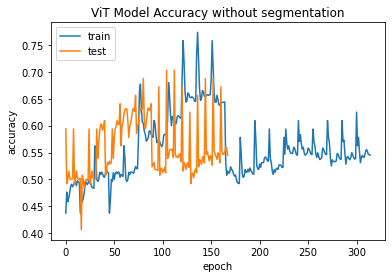

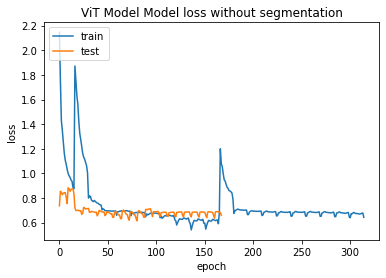

In [32]:
import matplotlib.pyplot as plt
# summarize history for accuracy
# summarize history for accuracy
plt.plot(non_seg_train_acc)
plt.plot(non_seg_val_acc)
plt.title('ViT Model Accuracy without segmentation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(non_seg_train_loss)
plt.plot(non_seg_val_loss)
plt.title('ViT Model Model loss without segmentation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## With Segmentation

In [24]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
import os
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize


X_ = "Database/Classification/Segmentation_Classification/ISIC2018/Segmented_Unet_transformer/"
train_ids = next(os.walk(X_))[2]
X = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

for  n,id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = X_ + id_
    img = imread(path)[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS), mode='constant', preserve_range=True)
    X[n] = img  #Fill empty X_train with values from img
    
import pandas as pd
data = pd.read_csv('Database/Classification/Supervised.csv')
Y = data.drop(['image'],axis=1)




100%|██████████| 1400/1400 [00:31<00:00, 44.29it/s]


In [96]:
os.walk(X_)

<generator object walk at 0x000001D48A3F5740>

In [25]:
import sklearn.model_selection as model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, train_size=0.65,test_size=0.35, random_state=101)

train_images = tf.cast(X_train.reshape((-1, 3, 128, 128)),dtype=tf.float32)
test_images = tf.cast(X_test.reshape((-1, 3, 128, 128)),dtype=tf.float32)
train_images, test_images = train_images / 255.0, test_images / 255.0

train_x = tf.data.Dataset.from_tensor_slices(train_images,)
train_y = tf.data.Dataset.from_tensor_slices(y_train)
train_dataset = tf.data.Dataset.zip((train_x,train_y))
test_x = tf.data.Dataset.from_tensor_slices(test_images)
test_y = tf.data.Dataset.from_tensor_slices(y_test)
test_dataset = tf.data.Dataset.zip((test_x,test_y))

In [26]:
tconf = TrainerConfig(max_epochs=10,batch_size=64, learning_rate=1e-3)
# sample model config.
model_config = {"image_size":128,
                "patch_size":4,
                "num_classes":2,
                "dim":64,
                "depth":3,
                "heads":4,
                "mlp_dim":128}

trainer = Trainer(ViT, model_config, train_dataset, len(train_images), test_dataset, len(test_images), tconf)

In [27]:
tf.autograph.experimental.do_not_convert(trainer.train())

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

<function tensorflow.python.autograph.impl.api.do_not_convert(func=None)>

In [28]:
seg_train_acc = train_acc
seg_train_loss = train_loss
seg_val_acc = val_acc
seg_val_loss = val_loss
seg_train_R = train_R
seg_val_R = val_R
seg_train_f1 = train_f1
seg_val_f1 = val_f1


print("Train Accuracy = ",train_acc[len(train_acc)-1])
print("Train Loss = ",train_loss[len(train_loss)-1])

print("Validation Accuracy = ",val_acc[len(val_acc)-1])
print("Validation Loss = ",val_loss[len(val_loss)-1])


print("Train Recall =",train_R[len(train_R)-1])

print("Validation Recall = ",val_R[len(val_R)-1])


print("Train F1Score =",train_f1[len(train_f1)-1])

print("Validation F1Score =",val_f1[len(val_f1)-1])


Train Accuracy =  0.545055
Train Loss =  0.6435879
Validation Accuracy =  0.544898
Validation Loss =  0.65892506
Train Recall = 0.5566079
Validation Recall =  0.848374
Train F1Score = 0.5645179725128633
Validation F1Score = 0.49836065740069874


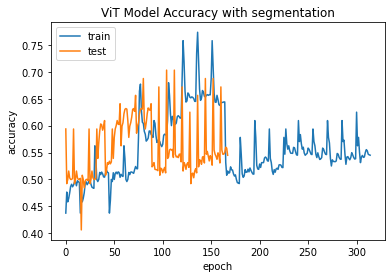

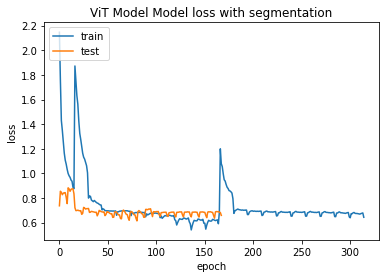

In [31]:
import matplotlib.pyplot as plt
# summarize history for accuracy
# summarize history for accuracy
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('ViT Model Accuracy with segmentation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('ViT Model Model loss with segmentation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

